# **Estratificacion del dengue en el departamento del Cauca, Colombia**

En este proyecto, trabajaremos con los siguientes datasets

- `entomologico.csv` : Contiene registros de muestras de insectos recolectados en diferentes localidades del departamento del Cauca, en donde cada registro tiene informacion sobre el numero de individuos, genero, especie, fecha y lugar de recoleccion.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/entomologico.csv')

## **Análisis de diversidad de especies**

###  **Cantidad de registros por especie**

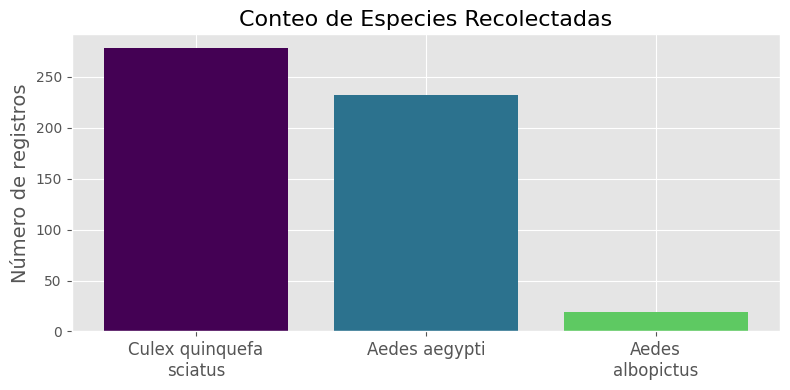


Distribución de especies:


,scientificName,Cantidad,Porcentaje
0,Culex quinquefasciatus,278,52.55
1,Aedes aegypti,232,43.86
2,Aedes albopictus,19,3.59


In [3]:
sc = df['scientificName'].value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(sc.index, sc.values, color=plt.cm.viridis(np.linspace(0, 0.75, len(sc))))

ax.set_title('Conteo de Especies Recolectadas', fontsize=16)
ax.set_ylabel('Número de registros', fontsize=14)

from textwrap import wrap
labels = ['\n'.join(wrap(l, 15)) for l in sc.index]

ax.set_xticks(range(len(sc.index)))
ax.set_xticklabels(labels, rotation=0, fontsize=12)

plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

# Mostrar tabla con porcentajes
sc_percent = pd.DataFrame({
    'Cantidad': sc.values,
    'Porcentaje': np.round((sc.values / sc.values.sum()) * 100, 2)
}, index=sc.index).sort_values('Cantidad', ascending=False).reset_index()

print('\nDistribución de especies:')
display(sc_percent)

###  **Indice de Shannon y Simpson**

El indice de Shannon es una medida estadistica utilizada para cuantificar la diversidad y riqueza de especies en un habitat. Este indice toma en cuenta no solo la cantidad de especies presentes, sino tambien la equidad en su distribucion, lo que ofrece una vision detallada de la biodiversidad de un ecosistema. Por otro lado, el indice de Simspon es una medida aritmetica ponderada que mide la probabilidad de que dos individuos seleccionados aleatoriamente de una muestra pertenezcan a la misma especie.

In [4]:
import re

location_diversity = df.groupby('locality').agg({
    'individualCount': 'sum',
    'scientificName': pd.Series.nunique
}).reset_index().rename(columns={
    'individualCount': 'Total de individuos',
    'scientificName': 'Especies únicas',
})

location_diversity['locality'] = location_diversity['locality'].str.replace(
    r'^Casa ubicada en el barrio (.+) de (.+)$', r'\1 (\2)',
    regex=True
)

diversity_indices = []

for location in df['locality'].unique():
    location_data = df[df['locality'] == location]
    species_counts = location_data.groupby('scientificName')['individualCount'].sum()
    total = species_counts.sum()
    
    # indice de shanon
    shannon = -np.sum((species_counts / total) * np.log(species_counts / total))
    
    # indice de simpson
    simpson = 1 - np.sum((species_counts / total)**2)
    
    diversity_indices.append({
        'Localidad': re.sub(
            r'^Casa ubicada en el barrio (.+) de (.+)$', 
            r'\1 (\2)', 
            location
        ),
        'Indice de Shannon': shannon,
        'Indice de Simpson': simpson,
        'Conteo de especies': len(species_counts),
        'Total de especies': total
    })
    
dff = pd.DataFrame(diversity_indices)
dff['Indice de Shannon'] = dff['Indice de Shannon'].round(2).astype(str)
dff['Indice de Simpson'] = dff['Indice de Simpson'].round(2).astype(str)

sdff = (
    dff.style.set_properties(
        **{"padding": "8px", "border": "1px solid #ddd", "text-align": "center"}
    )
    .set_table_styles(
        [
            {
                "selector": "th",
                "props": [
                    ("padding", "8px"),
                    ("background-color", "#222d32"),
                    ("text-align", "center"),
                    ("font-weight", "bold"),
                ],
            },
            {
                "selector": "caption",
                "props": [
                    ("caption-side", "top"),
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                ],
            },
        ]
    )
)


display(sdff)


,Localidad,Indice de Shannon,Indice de Simpson,Conteo de especies,Total de especies
0,Puerto Nuevo (Patía (El Bordo)),0.53,0.29,3,82
1,Olaya Herrera (Patía (El Bordo)),0.65,0.39,3,494
2,Balboita (Patía (El Bordo)),0.65,0.38,3,29
3,Fundadores (Patía (El Bordo)),0.51,0.33,2,91
4,Postobón (Patía (El Bordo)),0.24,0.1,3,223
5,Hueco Lindo (Patía (El Bordo)),0.46,0.28,2,41
6,Popular (Patía (El Bordo)),0.47,0.3,2,139
7,Libertador (Patía (El Bordo)),0.68,0.4,3,57
8,Colseguros (Miranda),0.55,0.36,2,25
9,Porvenir (Miranda),0.68,0.49,2,49


### **Análisis de distribución geográfica detallada**

En esta sección, analizaremos la distribución geográfica de las especies encontradas, visualizando:

1. Mapa de calor de concentración de especímenes
2. Distribución de especies dominantes por región
3. Comparación de diversidad entre diferentes ubicaciones geográficas

In [12]:
# Preparar datos de distribución geográfica
geo_distribution = df.groupby(['decimalLatitude', 'decimalLongitude']).agg({
    'individualCount': 'sum',
    'scientificName': 'nunique'
}).reset_index().rename(columns={'scientificName': 'species_count'})

print(geo_distribution)

     decimalLatitude  decimalLongitude  individualCount  species_count
0           1.112500        -76.323770                1              1
1           1.112719        -76.323765                3              2
2           1.112867        -76.323877                4              1
3           1.112887        -76.323821                5              1
4           1.112921        -76.324925                3              1
..               ...               ...              ...            ...
429         3.260109        -76.228073                1              1
430         3.260136        -76.229231                1              1
431         3.260143        -76.232152                1              1
432         3.260237        -76.228626                1              1
433         3.260309        -76.230626                2              1

[434 rows x 4 columns]
